# CS440/ECE448 Spring 2023
# MP04: Neural Networks

The first thing you need to do is to download this file: <a href="mp04.zip">mp04.zip</a>.  It has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp04_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* *__`pytorch_tutorial.ipynb`__*: A general introduction to PyTorch. You can ignore it if you want. 
* `data`: This directory contains the data.
* `tests`: This directory contains visible test.
* `reader.py`: This is an auxiliary program that you can use to read the data.

You will need to import `torch` and `numpy`. Otherwise, you should use only modules from the standard python library. `Do not use torchvision`.

The autograder doesn't have a GPU, so it will fail if you attempt to use `CUDA`.

This file (`mp04_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Goal
The goal of this assignment is to employ neural networks, nonlinear and multi-layer extensions of the linear perceptron, to classify images into `5 categories: ship (0), automobile (1), dog (2), frog (3), or horse (4)`. That is, your ultimate goal is to create a classifier that can tell what each picture depicts.

You will be using `PyTorch` (one of the most commonly used machine learning framworks) and NumPy libraries to implement these models. The PyTorch library will do most of the heavy lifting for you, but it is still up to you to implement the right high-level instructions to train the model.

You will need to consult the PyTorch documentation, to help you with implementation details. You may want to take a look at the provided PyTorch tutorial.

### Table of Contents

1. <a href="#section1">Dataset</a>
1. <a href="#section2">Dataloader</a>
1. <a href="#section3">Confusion Matrix</a>
1. <a href="#section4">Neural Network</a>
1. <a href="#grade">Grade Your Homework</a>
1. <a href="#extra">Extra credit</a>

<a id='section1'></a>
## Dataset

This section aims to help you get some ideas of the datasets we are using. Note that in this MP we have provided dataloaders for you, so you `do not need` to load any datasets by yourself.

The dataset consists of `3750` 31x31 colored (RGB) images (a modified subset of the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), provided by Alex Krizhevsky). This set is split for you into `2813` training examples and `937` development examples.

The function Load_dataset() in reader.py will unpack the dataset file (*you don't need to call this function in the MP*), returning images and labels for the training and development sets. Note that the images have been flattened, therefore the dimension of one image sample is `2883` (31 x 31 x 3).

In [13]:
import reader

In [14]:
# filepath to data
filepath = "./data/mp_data"
# load datasets, you don't need to call this function in the MP
train_set, train_labels, test_set, test_labels = reader.Load_dataset(filepath)
print("Shape of train set:", train_set.shape)
print("Shape of test set:", test_set.shape)

Shape of train set: (2813, 2883)
Shape of test set: (937, 2883)


In [15]:
# helper functions to visualize images, you can ignore the implementations

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

names = {0: "ship", 1: "automobile", 2: "dog", 3: "frog", 4: "horse"}

def show_train_image(index):
    img_c1 = Image.fromarray(train_set[index][: 961].reshape(31, 31))
    img_c2 = Image.fromarray(train_set[index][961: 1922].reshape(31, 31))
    img_c3 = Image.fromarray(train_set[index][1922: ].reshape(31, 31))
    img_rgb = np.zeros((31, 31, 3), 'uint8')
    img_rgb[..., 0] = img_c1
    img_rgb[..., 1] = img_c2
    img_rgb[..., 2] = img_c3
    fig = plt.figure()
    plt.axis('off')
    plt.imshow(img_rgb)
    title = "Train[" + str(index) + "]  --  " + names[train_labels[index].item()] + " -- label " + str(train_labels[index].item())
    plt.title(title)

def show_test_image(index):
    img_c1 = Image.fromarray(test_set[index][: 961].reshape(31, 31))
    img_c2 = Image.fromarray(test_set[index][961: 1922].reshape(31, 31))
    img_c3 = Image.fromarray(test_set[index][1922: ].reshape(31, 31))
    img_rgb = np.zeros((31, 31, 3), 'uint8')
    img_rgb[..., 0] = img_c1
    img_rgb[..., 1] = img_c2
    img_rgb[..., 2] = img_c3
    fig = plt.figure()
    plt.axis('off')
    plt.imshow(img_rgb)
    title = "Test[" + str(index) + "]  --  " + names[test_labels[index].item()] + " -- label " + str(test_labels[index].item())
    plt.imshow(img_rgb)
    plt.title(title)

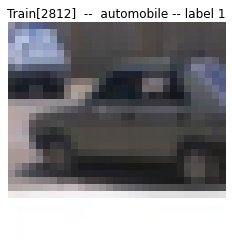

In [16]:
# You can use the helper function to visualize training set. The parameter is the index of image to visualize.
show_train_image(2812)      # feel free to change the number. note that the size of training set is 2813

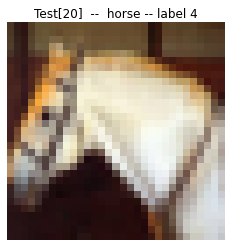

In [17]:
# You can use the helper function to visualize testing set. The parameter is the index of image to visualize.
show_test_image(20)     # feel free to change the number. note that the size of testing size is 937

<a id='section2'></a>
## Dataloaders

If you are not sure what dataloaders are, please refer to the tutorial or PyTorch document. With dataloaders, you can iterate through the datasets easily.In this MP, we have provided dataloaders for training set and testing set, respectively. 

In [18]:
# Generate dataloaders
# you don't need to call these functions in MP, train_loader and test_loader are passed to your function as arguments
train_set_p, test_set_p  = reader.Preprocess(train_set, test_set)
train_loader, test_loader = reader.Get_DataLoaders(train_set_p, train_labels, test_set_p, test_labels, batch_size=100)

Each iteration below returns a batch of train_features and train_labels (in this MP, we set up batch size equal to 100, so each batch contains 100 feature and label tensors respectively). You can pass the feature batch to your neural network, and then compare the label batch with your predictions. Let's iterate over the dataset and see what each batch looks like. 

Labels:   
`ship: 0, automobile: 1, dog: 2, frog: 3, horse: 4`

In [19]:
batch_index = 0
# Iterate over the dataloader
for features, labels in train_loader:
    # you can train your network with the feature and label batches here
    print("Batch #", batch_index)
    print("Feature shape:", features.shape)
    print(features, "\n")
    print("Label shape:", labels.shape)
    print(labels, "\n\n")
    batch_index += 1

Batch # 0
Feature shape: torch.Size([100, 2883])
tensor([[ 0.3525,  0.3150, -0.6970,  ...,  1.2380,  1.2221,  1.3589],
        [ 0.8684,  0.9081,  0.9093,  ...,  1.0154,  1.0167,  0.9519],
        [ 0.3932,  0.3839, -0.2262,  ..., -0.6230, -0.5951, -0.5977],
        ...,
        [-0.4756,  0.1494,  0.5631,  ..., -0.6230, -0.7689, -1.1299],
        [ 1.4793,  1.5012,  1.5324,  ...,  0.9199,  0.9219,  0.8737],
        [-0.5027, -0.5816, -0.5309,  ...,  1.0631,  1.0483,  0.9989]]) 

Label shape: torch.Size([100])
tensor([0, 0, 0, 3, 1, 1, 0, 1, 4, 4, 4, 2, 1, 0, 3, 4, 1, 1, 3, 1, 1, 4, 1, 1,
        4, 4, 3, 2, 0, 4, 2, 1, 0, 1, 0, 3, 0, 1, 0, 4, 4, 0, 4, 0, 3, 2, 2, 3,
        4, 2, 3, 3, 1, 2, 3, 3, 2, 2, 2, 2, 1, 0, 4, 0, 3, 3, 0, 3, 1, 0, 0, 2,
        1, 3, 0, 0, 2, 4, 3, 2, 3, 2, 2, 3, 3, 2, 0, 3, 4, 0, 1, 0, 3, 1, 0, 0,
        4, 2, 0, 1]) 


Batch # 1
Feature shape: torch.Size([100, 2883])
tensor([[-1.7381, -1.7541, -1.7771,  ..., -1.7523, -1.7487, -1.7403],
        [-0.3127, -0.

<a id='section3'></a>
## Confusion Matrix

The top-level program grade.py returns two types of feedback about your model.

- The accuracy on the testing set.
- A confusion matrix for the testing set.

A confusion matrix is a very useful tool for evaluating multi-class classification problems, as it helps in identifying possible sources of imbalance in your dataset - and can offer precious insights into possible biases in your training procedure.

Specifically, in a classification problem with k classes, a confusion matrix will have k rows and k columns. Each row corresponds to the ground truth label of the data points - and each column refers to the predicted label by your classifier. Each entry on the matrix contains a count of the corresponding tuple (ground_truth label, predicted_label). In other words, all elements in the diagonal of this square matrix have been correctly classified - and all other elements count as mistakes. For instance, if your matrix has many entries in [0,1]. This will mean that your classifier tends to mistake points belonging to class 0 for points belonging to class 1. Further details can be found on this [Wikipedia page](https://en.wikipedia.org/wiki/Confusion_matrix).

<a id='section4'></a>
## Neural Network

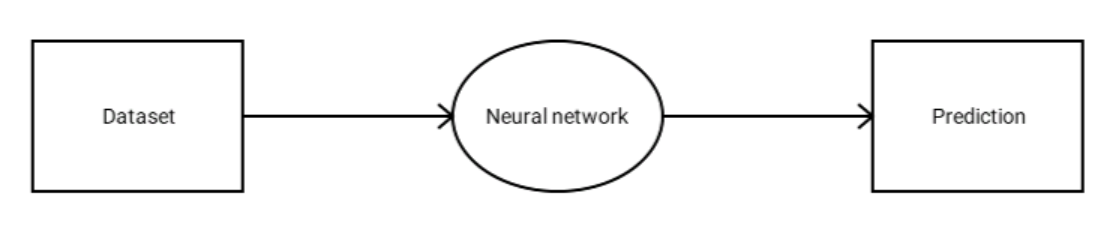

Now it's time for you to create a neural network. You will implement a neural network in `Class NeuralNet`, specify a loss function and optimizer in the `function fit()`, and write a training loop in `function train()`.   
*__In each training iteration, the input of your network is a batch of preprocessed image data of size (batch size, 2883). The number of neurons in the output layer should be equal to the number of categories.  
For this assignment, you can use [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Notice that because PyTorch's CrossEntropyLoss incorporates a softmax function, you do not need to explicitly include an normalization function in the last layer of your network__*.

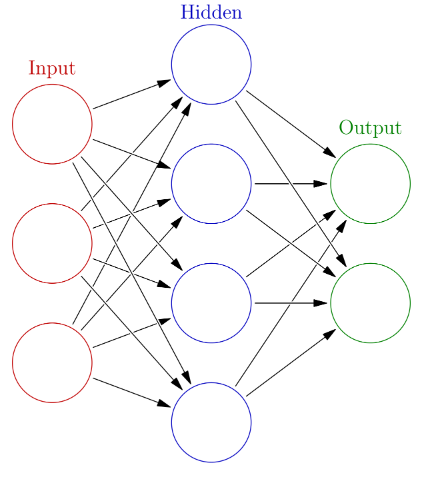

To get a full score, the accuracy of your network must be above `0.61 on the visible testing set`, and `above 0.59 on the hidden testing set`. The structure of the neural network is completely up to you. You should be able to get around 0.62 testing-set accuracy with a two-layer network with no more than 200 hidden neurons.

Notice that the autograder will pass in the number of training epochs and the batch size. You don't control those. However, you do control the neural net's learning rate. If you are confident about a model you have implemented but are not able to pass the accuracy thresholds on gradescope, try increasing the learning rate. Be aware, however, that using a very high learning rate may worse performance since the model may begin to oscillate around the optimal parameter settings.

In [208]:
import submitted
import importlib

After you have implemented a network, you can use the code below to test your model.

In [209]:
# Helper functions to test your model, you can ignore the implementations

def ComputeAccuracy(model):
    pred_values = model(test_set_p)  # Predicted value of the testing set
    pred_values = pred_values.detach().numpy()  # Convert the tensor to a numpy array
    pred_labels = np.argmax(pred_values, axis=1)  # Predicted labels
    accuracy, conf_mat = reader.compute_accuracies(pred_labels, test_labels)
    print("Accuracy:", accuracy)
    print("Confusion matrix:")
    print(conf_mat, "\n")
    
def Predict(model, index):
    pred_values = model(test_set_p[index])
    pred_values = pred_values.detach().numpy()  # Convert the tensor to a numpy array
    pred_labels = np.argmax(pred_values)  # Predicted labels
    show_test_image(index)
    print("Your prediction:", names[pred_labels.item()],)

In [210]:
# Train your network
reader.init_seeds(42) # fix random seed
importlib.reload(submitted)
model, loss_fn, optimizer = submitted.fit(train_loader, test_loader, 50) # the last parameter is the number of epochs

Epoch # 0
Epoch # 1
Epoch # 2
Epoch # 3
Epoch # 4
Epoch # 5
Epoch # 6
Epoch # 7
Epoch # 8
Epoch # 9
Epoch # 10
Epoch # 11
Epoch # 12
Epoch # 13
Epoch # 14
Epoch # 15
Epoch # 16
Epoch # 17
Epoch # 18
Epoch # 19
Epoch # 20
Epoch # 21
Epoch # 22
Epoch # 23
Epoch # 24
Epoch # 25
Epoch # 26
Epoch # 27
Epoch # 28
Epoch # 29
Epoch # 30
Epoch # 31
Epoch # 32
Epoch # 33
Epoch # 34
Epoch # 35
Epoch # 36
Epoch # 37
Epoch # 38
Epoch # 39
Epoch # 40
Epoch # 41
Epoch # 42
Epoch # 43
Epoch # 44
Epoch # 45
Epoch # 46
Epoch # 47
Epoch # 48
Epoch # 49


Let's print the output for a random image in testing set, note that the output varies on a network-by-network basis, so your network's output will probably be different from the one below. Since we have five categories, the output is a 5-dimensional tensor. The label 0 is the one with the largest value in the output tensor, therefore this image is classified by our model into label 0, which is a ship.

tensor([17.7139,  0.0910,  8.0413,  0.0000,  0.0000], grad_fn=<ReluBackward0>)


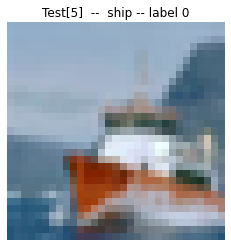

In [211]:
# Let's print the output for a random image in testing set
index = 5
show_test_image(index)

output = model(test_set_p[index])
print(output)

In [212]:
# You can use the helper function to compute the accuracy and confusion matrix
ComputeAccuracy(model)

Accuracy: 0.6221985058697972
Confusion matrix:
[[150.  25.   8.   1.   6.]
 [ 31. 125.  14.  16.  16.]
 [ 11.  10. 113.  28.  24.]
 [  6.  10.  68.  89.  13.]
 [ 14.   6.  36.  11. 106.]] 



You can use the helper function to compare your network's prediction with the true label.

Good prediction!

Your prediction: automobile


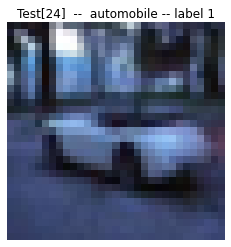

In [150]:
# make predictions
Predict(model, 24) # the number is the index of image in testing sets, feel free to change it

Bad prediction!

Your prediction: automobile


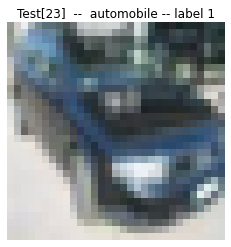

In [151]:
Predict(model, 23) # the number is the index of image in testing sets, feel free to change it

<a id='section2'></a>

<a id='grade'></a>
## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases.

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [92]:
!python grade.py

Traceback (most recent call last):
  File "/Users/aahanthapliyal/Desktop/CS440/mp04/grade.py", line 2, in <module>
    from gradescope_utils.autograder_utils.json_test_runner import JSONTestRunner
ModuleNotFoundError: No module named 'gradescope_utils'


If you got any 'E' marks, it means that your code generated some runtime errors, and you need to debug those.

If you got any 'F' marks, it means that your code ran without errors, but that it generated results that are different from the solutions.

If neither of those things happened, and your result was a series of dots, then your code works perfectly.  

If you're not sure, you can try running grade.py with the -j option.  This will produce a JSON results file, in which the best score you can get is 50.

Now you should try uploading `submitted.py` to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

Gradescope will run the same visible tests that you just ran on your own machine, plus some additional hidden tests.  It's possible that your code passes all the visible tests, but fails the hidden tests.  If that happens, then it probably means that you hard-coded a number into your function definition, instead of using the input parameter that you were supposed to use.  Debug by running your function with a variety of different input parameters, and see if you can get it to respond correctly in all cases.

Once your code works perfectly on Gradescope, with no errors, then you are done with the MP.  Congratulations!

<a id='extra'></a>
## Extra credit

You can earn extra credits worth 10% of this MP if the accuracy of your network is above `0.66`

### Some tips:
1. Choose a good activation function.
2. L2 Regularization.
3. Convolutional neural network.

<a id='section4'></a>

<a id='grade'></a>